Google Colab Nootebook with GPU 

In [1]:
!pip install pickle5

     |████████████████████████████████| 133kB 8.2MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219264 sha256=7ef935da9700f5546a7d0ea471b83c59784e33cd479b8d48765d44b127eed267
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [7]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import tree
import xgboost as xgb
from scipy import sparse
import pickle5 as pickle
from sklearn.metrics import log_loss as loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
infile = open('/content/drive/MyDrive/X_tr.pkl','rb')
X_tr = pickle.load(infile)

infile = open('/content/drive/MyDrive/X_cr.pkl','rb')
X_cr = pickle.load(infile)

infile = open('/content/drive/MyDrive/X_te.pkl','rb')
X_te = pickle.load(infile)

In [5]:
infile = open('/content/drive/MyDrive/y_train.pkl','rb')
y_train = pickle.load(infile)
print(y_train.shape,X_tr.shape)

infile = open('/content/drive/MyDrive/y_cv.pkl','rb')
y_cv = pickle.load(infile)
print(y_cv.shape,X_cr.shape)


infile = open('/content/drive/MyDrive/y_test.pkl','rb')
y_test = pickle.load(infile)
print(y_test.shape,X_te.shape)

(198091,) (198091, 633)
(84897,) (84897, 633)
(121281,) (121281, 633)


In [6]:
X_tr=sparse.csr_matrix(np.array(X_tr))
X_cr=sparse.csr_matrix(np.array(X_cr))
X_te=sparse.csr_matrix(np.array(X_te))

# Distribution of data in train, cross validate and test set 

% of not duplicate question in train set   63.118970574130074 %
% of duplicate question in train set  36.881029425869926 %



Text(0.5, 1.0, 'Data distribution of train set ')

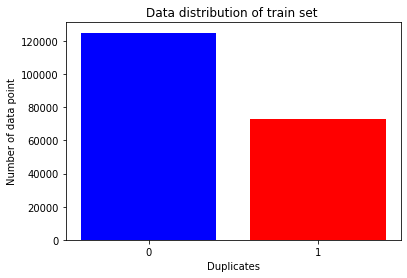

In [13]:
print('% of not duplicate question in train set  ',((y_train.value_counts().values[0]*100)/sum(y_train.value_counts().values)),'%')
print('% of duplicate question in train set ',((y_train.value_counts().values[1]*100)/sum(y_train.value_counts().values)),'%')
print( )
plt.bar(['0','1'],y_train.value_counts().values,color=['blue','red'])
plt.xlabel('Duplicates')
plt.ylabel('Number of data point')
plt.title('Data distribution of train set ')

% of not duplicate question in test set   63.087375598815974 %
% of duplicate question in test set  36.912624401184026 %



Text(0.5, 1.0, 'Data distribution of test set ')

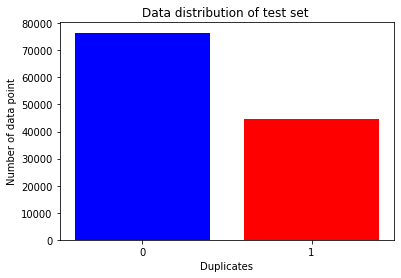

In [11]:
print('% of not duplicate question in test set  ',((y_test.value_counts().values[0]*100)/sum(y_test.value_counts().values)),'%')
print('% of duplicate question in test set ',((y_test.value_counts().values[1]*100)/sum(y_test.value_counts().values)),'%')
print( )
plt.bar(['0','1'],y_test.value_counts().values,color=['blue','red'])
plt.xlabel('Duplicates')
plt.ylabel('Number of data point')
plt.title('Data distribution of test set ')

% of not duplicate question in cv set   62.97042298314428 %
% of duplicate question in cv set  37.02957701685572 %



Text(0.5, 1.0, 'Data distribution of cross validate set ')

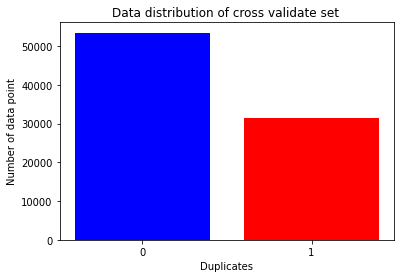

In [12]:
print('% of not duplicate question in cv set  ',((y_cv.value_counts().values[0]*100)/sum(y_cv.value_counts().values)),'%')
print('% of duplicate question in cv set ',((y_cv.value_counts().values[1]*100)/sum(y_cv.value_counts().values)),'%')
print( )
plt.bar(['0','1'],y_cv.value_counts().values,color=['blue','red'])
plt.xlabel('Duplicates')
plt.ylabel('Number of data point')
plt.title('Data distribution of cross validate set ')

# Hyperparameter Tuning 

In [14]:
#list to store logloss score for different hyperparameter
train_logloss = []
cv_logloss = []

#parameters
Number_of_model= [50,100,300,600,1000]
learning_rate=[0.0001,0.001,0.01,0.1,1]


for i in tqdm(Number_of_model):
    l_train=[]
    l_cv=[]
    for j in learning_rate:
        
        clf = xgb.XGBClassifier(  n_estimators=i,learning_rate=j,booster='gbtree',tree_method='gpu_hist', gpu_id=0,subsample=0.5,colsample_bytree=0.7,reg_lambda=0.001,eval_metric= 'logloss',use_label_encoder=False)
        clf.fit(X_tr,y_train)

        #predicting the probability score for train and cross validate set 
        y_train_proba=clf.predict_proba(X_tr)
        y_CV_proba=clf.predict_proba(X_cr)

        #storing the hyperparameter
        # storing score for each learing rate for given number of model 
        l_train.append(loss(y_train,y_train_proba))
        l_cv.append(loss(y_cv,y_CV_proba))

    # for each number of model
    train_logloss.append(l_train)
    cv_logloss.append(l_cv)

arr_train=np.asarray(train_logloss)
arr_cv=np.asarray(cv_logloss)




100%|██████████| 5/5 [41:57<00:00, 503.42s/it]


[Text(767.7272727272725, 0.5, 'learning_rate'),
 Text(0.5, 33.0, 'Number_of_model'),
 Text(0.5, 1.0, 'cv set')]

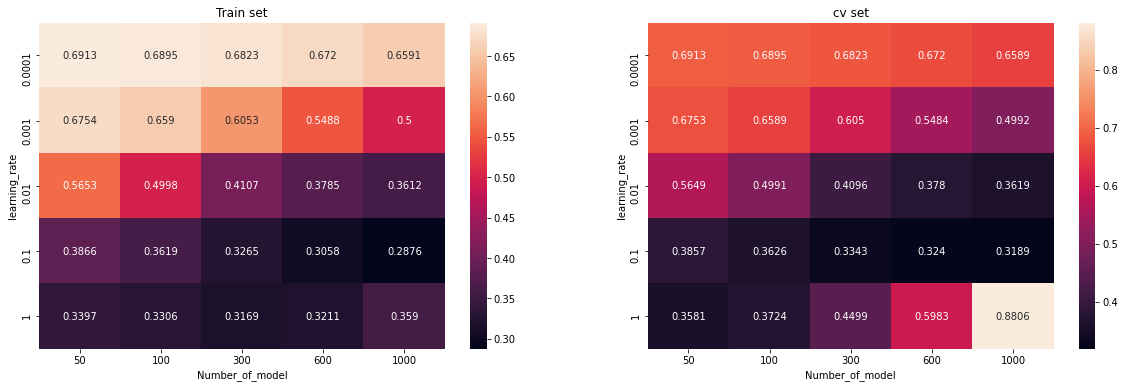

In [15]:

fig,axes=plt.subplots(1,2,figsize=(20,6))
sns.heatmap(arr_train.T,xticklabels=Number_of_model,yticklabels=learning_rate,annot=True,ax=axes[0],fmt='.4g').set(xlabel='Number_of_model',ylabel='learning_rate',title='Train set')
sns.heatmap(arr_cv.T,xticklabels=Number_of_model,yticklabels=learning_rate,annot=True,ax=axes[1],fmt='.4g').set(xlabel='Number_of_model',ylabel='learning_rate',title='cv set')

# Performing Xgboost model on best hyper parameter 
number of estimator =1000
learning rate =0.1

In [16]:
clf = xgb.XGBClassifier(  n_estimators=1000,learning_rate=0.1,booster='gbtree',tree_method='gpu_hist', gpu_id=0,subsample=0.5,colsample_bytree=0.7,reg_lambda=0.001,eval_metric= 'logloss',use_label_encoder=False)
clf.fit(X_tr,y_train)


In [17]:
#  predicted probability valure for train set 
y_train_proba=clf.predict_proba(X_tr)
#  predicted probability valure for cross validate set 
y_CV_proba=clf.predict_proba(X_cr)

print('log loss for train set ',loss(y_train,y_train_proba))
print('log loss for cv set ',loss(y_cv, y_CV_proba))
print( )
print('Our model is not over fitting ')

log loss for train set  0.28756949008510263
log loss for cv set  0.31887041677661654

Our model is not over fitting 


Text(0.5, 1.0, 'Cnfusion Matrix')

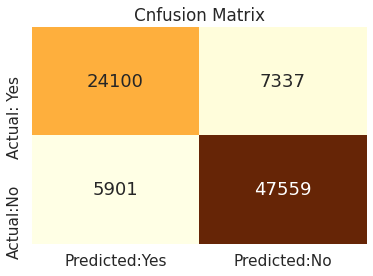

In [18]:
# predicting the value of y for cv set 
y_predicted=clf.predict(X_cr)

conf_matrix=confusion_matrix(y_cv,y_predicted,labels=[1,0])
con=pd.DataFrame(conf_matrix,index=['Actual: Yes',"Actual:No"],columns=['Predicted:Yes','Predicted:No'])
sns.set(font_scale=1.4)
sns.heatmap(con,annot=True,cmap="YlOrBr",cbar=False,fmt='g',annot_kws={"size": 18})
plt.title('Cnfusion Matrix')

In [19]:
print('Accuracy',accuracy_score(y_cv, y_predicted))
print(classification_report(y_cv, y_predicted))


Accuracy 0.8440698729048141
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     53460
           1       0.80      0.77      0.78     31437

    accuracy                           0.84     84897
   macro avg       0.83      0.83      0.83     84897
weighted avg       0.84      0.84      0.84     84897



<h1> Performming trained model on test set</h>

In [20]:
y_test_proba=clf.predict_proba(X_te)

In [21]:
print('log loss for train set ',log_loss(y_train,y_train_proba))
print('log loss for test set ',log_loss(y_test, y_test_proba))


log loss for train set  0.28756949008510263
log loss for test set  0.3193688398347328


Text(0.5, 1.0, 'Cnfusion Matrix for Test set ')

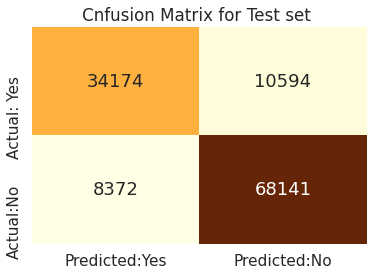

In [22]:
y_test_predicted=clf.predict(X_te)

conf_matrix=confusion_matrix(y_test,y_test_predicted,labels=[1,0])
con=pd.DataFrame(conf_matrix,index=['Actual: Yes',"Actual:No"],columns=['Predicted:Yes','Predicted:No'])
sns.set(font_scale=1.4)
sns.heatmap(con,annot=True,cmap="YlOrBr",cbar=False,fmt='g',annot_kws={"size": 18})
plt.title('Cnfusion Matrix for Test set ')

In [24]:
print('Accuracy',accuracy_score(y_test, y_test_predicted))
print(classification_report(y_test, y_test_predicted))


Accuracy 0.8436193632968065
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     76513
           1       0.80      0.76      0.78     44768

    accuracy                           0.84    121281
   macro avg       0.83      0.83      0.83    121281
weighted avg       0.84      0.84      0.84    121281

